*this analysis is in almost everything similar to the pure pixel except for extra steps for noise generation*

# Step 1: mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Perhaps this step can be skipped by saving directly to the workspace

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Step 2: install the packages

In [ ]:
#package instalation

#Installing PROSAIL
!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
!pip install pysptools

     |████████████████████████████████| 153kB 2.6MB/s 
     |████████████████████████████████| 8.1MB 2.4MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp36-none-any.whl size=8133750 sha256=30a1ae6fd3e25414fb357edfaeff69e51aa982caf6808263327bdfe01164d6c1
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools


#TensorFlow update correction

Tensor flow has been updated so we will uninstall the new version and push in the old version which works well on my case

- Notice: this only has to be run if tf > 1.4.0
- if you do this after you load the package, everything will have to be restarted

In [ ]:
#!pip uninstall tensorflow

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0


In [ ]:
#!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 105kB/s 
     |████████████████████████████████| 3.2MB 48.8MB/s 
     |████████████████████████████████| 491kB 53.9MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


# Step 3 Import the packages

In [ ]:
#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

#the beutiful R like data frame
import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#a few more stuff for random
import random as rdm
import math



#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance


from sklearn.model_selection import KFold # import KFold

#machine learning stuff
#NEURAL NETWORK - Keras will be updated soon so this colab will also have to be changed

from sklearn.neural_network import MLPRegressor as ANN_reg #this is a simpler neural network package
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#ignore the warning for now

#Random FOREST
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 

#Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

#aux functions
from sklearn.preprocessing import MinMaxScaler #this is to standardize the input data [not used for now]
from sklearn import metrics

#for model storing -sklearn
import pickle

#for model storing keras
from keras.models import model_from_json


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adadelta, Adam, rmsprop

from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input
from keras.models import Sequential, Model
from keras.utils import np_utils

from sklearn.model_selection import KFold 
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from numpy import savetxt,loadtxt

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


# Step 4.1: set up of custom auxiliar functions

- First we have to set of custom function to facilitate the loop calls


In [ ]:
def custom_prosail(cab,cw,cm,lai):
  import prosail
  #default parameters
  n= 1.
  car=10.
  cbrown=0.01
  typelidf=1 #this is the default option
  lidfa = -1 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot= 0.01 #hotspot parameters - got this from R package https://www.rdocumentation.org/packages/hsdar/versions/0.4.1/topics/PROSAIL
  #sun and viewing angle
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  #for now i put them by hand but they should be an input of a custom function
  #tts=sol_zen #solar zenith angle
  #tto=inc_zen #sensor zenith angle
  #psi=raa
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,
                                 hspot,
                                 tts,tto,psi,
                                 typelidf, lidfb,
                                 prospect_version="D",
                                 factor='SDR', 
                                 rsoil=.5, psoil=.5)
  return(rho_out)

def Prosail2S2(path2csv,spectra_input):
  #importing pandas
  import pandas as pd
  import numpy
  import numpy as np
  #upload a S2_Response.csv from https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/document-library/-/asset_publisher/Wk0TKajiISaR/content/sentinel-2a-spectral-responses

  s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
  #chekc which row you are actually extracting

  s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
  spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
  rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
  w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

  output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

  return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/content/drive/My Drive/S2_Response.csv"
#filepath="/content/S2_Responses_S2B.csv"
#filepath="/content/drive/My Drive/S2_Response.csv"


def Gen_spectra_data(traits):
  k = 1
  #pd_train_traits=traits
  #print(range(len(traits)))
  for i in range(len(traits)):
    #n_t = pd_train_traits["n"][i]
    cab_t = traits["cab"][i]
    #car_t = pd_train_traits["car"][i]
    #cbrown_t = pd_train_traits["cbrown"][i]
    cw_t = traits["cw"][i]
    cm_t = traits["cm"][i]
    lai_t = traits["lai"][i]

    if k == 1:
      tr_rho_s = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_s = Prosail2S2(filepath,tr_rho_s)
      #plt.plot ( x, tr_rho_s, ':', label="Training prosail")
      #plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(cab_t,cw_t,cm_t,lai_t)
      tr_rho_t = Prosail2S2(filepath,tr_rho_t)
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      #plt.plot ( x, tr_rho_t, ':')

    k = k+1


  rho_samples=tr_rho_s


  return rho_samples




#Function to store the outputs into a table
column_names=["Model",
              "NoiseLevel",
              "NoiseType",
              "OutOfBag",
              "KFold_tr_samples",
              "KFold_vl_samples",
              "Variable",
              "Fold_nr",
              "ExplVar",
              "Max_err",
              "Mean_abs_Err",
              "Mean_sqr_err",
              #"Mean_sqr_lg_err",
              "Median_abs_err",
              "r2",
              "MAPE",
              "ModelName"]
              #"Mean_poiss_dev",
              #"Mean_gamma_dev"]
              #"Mean_tweed_dev"]

#mape is not existant in the package so we have to create it:
#https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
#from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  #Here, the file is used for saving
  #creating a df to receive the data


def calc_metrics(MDL,NoiseLevel,NoiseType,oob_samples,kf_tr,kf_vl,Variable,Fold,Ref,Pred,Modelname):

  out_list = {"Model":MDL,
              "NoiseLevel":NoiseLevel,
              "NoiseType":NoiseType,
              "OutOfBag":oob_samples,
              "KFold_tr_samples":kf_tr,
              "KFold_vl_samples":kf_vl,
              "Variable":Variable,
              "Fold_nr":Fold,
              "ExplVar": metrics.explained_variance_score(Ref, Pred),
              "Max_err": metrics.max_error(Ref, Pred),
              "Mean_abs_Err": metrics.mean_absolute_error(Ref, Pred),
              "Mean_sqr_err": metrics.mean_squared_error(Ref, Pred),
              "Median_abs_err" : metrics.median_absolute_error(Ref, Pred),
              "r2": metrics.r2_score(Ref, Pred),
              "MAPE": mean_absolute_percentage_error(Ref, Pred),
              "ModelName":Modelname}


  return out_list

# Extra function for noise generation

Combined noise & inverted noise based on the equations 4 and 5 on: 

https://www.mdpi.com/2072-4292/7/8/10321/html#B31-remotesensing-07-10321



In [ ]:
def combined_noise(ref,sigma):

  #ref is an input vector and sigma is the standar deviation of the noise

  #this format implies some values go negative or above 1 which is terrible

  #the multiplier parameter is solid
  #mp_noise = ref*(1 + np.random.normal(0,scale=2*sigma,size=ref.shape[0]))

  #this form makes the value go over 1 and under 0 from time to time
  #ad_noise = 0#+np.random.normal(0,sigma)

  #truncated version - the limits are on 2*sigma to give it a leeway 
  #ad_noise = 0+stats.truncnorm.rvs(0-sigma*2,0+sigma*2,loc=0,scale=sigma,size=ref.shape[0])

  #the only way i can think to force it doesn't go over 1 or under 0, is to use a naive verifier
  
  #sigma is any value between 0 and 1, reflecting "% percent error"
  #notice i give leeway to sigma by doubling the interval but the truncated version should be stronger againt bad values
  
  mp_noise = ref*(1 + stats.truncnorm.rvs(0-sigma*4,0+sigma*4,loc=0,scale=sigma*2,size=ref.shape[0]))
  ad_noise = 0+stats.truncnorm.rvs(0-sigma*2,0+sigma*2,loc=0,scale=sigma,size=ref.shape[0])
  out_ref = mp_noise+ ad_noise


  #this looks fun but breaks the speed of processing....
  # while max(out_ref) > 1 or min(out_ref)<0:
  #   #print("i am in the loop!")
  #   mp_noise = ref*(1 + stats.truncnorm.rvs(0-sigma*4,0+sigma*4,loc=0,scale=sigma*2,size=ref.shape[0]))
  #   ad_noise = 0+stats.truncnorm.rvs(0-sigma*2,0+sigma*2,loc=0,scale=sigma,size=ref.shape[0])
  #   out_ref = mp_noise+ ad_noise
  #   #print(out_ref)

  #making everything that goes under, be 0 or 1
  out_ref[out_ref>1]=1
  out_ref[out_ref<0]=0

  return out_ref

def inverted_noise(ref,sigma):

  #ref is an input vector and sigma is the standar deviation of the noise


  #in this case, both of these are producing improper results - less than 0 or more than 1 oftne. 
  #mp_noise = 1-(abs(1-ref)*(1 + np.random.normal(0,scale=2*sigma,size=ref.shape[0])))
  #ad_noise = 0#+np.random.normal(0,sigma)

  mp_noise = 1-(1-ref)*(1 + stats.truncnorm.rvs(0-sigma*4,0+sigma*4,loc=0,scale=sigma*2,size=ref.shape[0]))
  ad_noise = 0+stats.truncnorm.rvs(0-sigma*2,0+sigma*2,loc=0,scale=sigma,size=ref.shape[0])

  out_ref = mp_noise+ ad_noise

  #this looks fun but breaks the speed of processing...
  # while max(out_ref) > 1 or min(out_ref)<0:
  #   #print("i am in the loop!")
  #   mp_noise = 1-(1-ref)*(1 + stats.truncnorm.rvs(0-sigma*4,0+sigma*4,loc=0,scale=sigma*2,size=ref.shape[0]))
  #   ad_noise = 0+stats.truncnorm.rvs(0-sigma*2,0+sigma*2,loc=0,scale=sigma,size=ref.shape[0])
  #   out_ref = mp_noise+ ad_noise
  #   #print(out_ref)  while 


  #making everything that goes under, be 0 or 1
  out_ref[out_ref>1]=1
  out_ref[out_ref<0]=0

  return out_ref





For testing: generating noise for one run of prosail

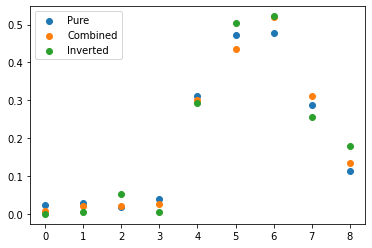

[0.02246956 0.02850029 0.01793622 0.04028608 0.31156409 0.47324267
 0.47773286 0.28741394 0.11398075]
[0.00743674 0.02180222 0.02173483 0.02516667 0.30189327 0.43433183
 0.52141294 0.3106867  0.13361433]
[0.         0.00625446 0.05281358 0.00380104 0.29189236 0.50384317
 0.52213677 0.25558124 0.17986032]


In [ ]:
cab = 80
cw  = 0.006
cm  = 0.006
lai = 3 
#creating input
trait_dic = {"cab":[cab],"cw":[cw],"cm":[cm],"lai":[lai]}
trait_pd = pd.DataFrame.transpose(pd.DataFrame([cab,cw,cm,lai]))
trait_pd.columns = ["cab","cw","cm","lai"]
trait_pd
np_spect = Gen_spectra_data(trait_pd)[[1,2,3,4,5,6,8,11,12]]
np_spect.shape
#plot the "pure signal"
np_spect_noise1 = combined_noise(np_spect,.1) #0.05 of error
np_spect_noise2 = inverted_noise(np_spect,.1) #0.05 of error
x_axis = range(9)
fig = plt.figure()
ax1 = fig.add_subplot(111)
#,label="Pure"
ax1.scatter(x_axis,np_spect,label="Pure")
ax1.scatter(x_axis,np_spect_noise1,label="Combined")
ax1.scatter(x_axis,np_spect_noise2,label="Inverted")
plt.legend(loc ="upper left")
plt.show()
print(np_spect)
print(np_spect_noise1)
print(np_spect_noise2)
#rule of thumb the error on the inverted should be higher in the first bands 

# Step 4.2: Setting up machine learning models 


In [ ]:

#initializing the random forest
#optimized

from sklearn.gaussian_process.kernels import RBF,DotProduct,Matern,ExpSineSquared,RationalQuadratic

#Random forest
#initializing the random forest
#optimized

def rfr_call():

  mdl = RandomForestRegressor(n_estimators=850,random_state=0,
                               min_samples_leaf=0.0005292768087778988,
                               min_samples_split=0.0028599513810681296,
                               verbose=0) 
  return mdl

#test cals to the function
rfr_ml_comb = rfr_call()
rfr_ml_inve = rfr_call()

#gaussian processes with default acquisition function
#initializing the gaussian process -optimized
K_ratQ = RationalQuadratic(length_scale_bounds="fixed",alpha_bounds="fixed")

def gpr_call(noise_val):
  mdl = GaussianProcessRegressor(kernel=K_ratQ,
                                 alpha=noise_val,
                                 n_restarts_optimizer=80, # -> 1*RBF(1.0) is the default kerneºl
                                 normalize_y=True,
                                 random_state=0,
                                 )
  
  return mdl

#test calls to the function 
gpr_ml_comb = gpr_call(.5)
gpr_ml_inve = gpr_call(.5) 


Setting up the neural networks

In [ ]:
hiddenlayer = {0:'one',1:'two',2:'three'}
modeltype = {0: 'MTST',1: 'MTSTST',2: 'MTMTST',3: 'MTMTSTST'}
activation_f = {0:'linear', 1:'sigmoid', 2:'tanh',3:'exponential',4:'softplus',5:'relu',6:'softsign'}
units_shared = {0: 5,1: 10,2: 15,3: 20}
units_traits = {0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10}
optimizer = {0: 'adam',1: 'RMSprop',2: 15,3: 'Adadelta'}

param_dict_st_ann = {'aa_hiddenlayers':hiddenlayer[2],
              'activation_3_1': activation_f[6],
              'activation_3_2': activation_f[6],
              'activation_3_3': activation_f[5],
              'optimizer_3': optimizer[0],
              'units_3_1': units_shared[3],
              'units_3_2': units_shared[3],
              'units_3_3': units_shared[2]}
#param_dict_st_ann

param_dict_mtn = {'aaa_modeltype': modeltype[3],
              'activation_MTMTSTST': activation_f[2],
              'activation_MTMTSTST2': activation_f[6],
              'activation_cab_MTMTSTST1': activation_f[4],'activation_cab_MTMTSTST2': activation_f[1],
              'activation_cm_MTMTSTST1': activation_f[5],'activation_cm_MTMTSTST2': activation_f[1],
              'activation_cw_MTMTSTST1': activation_f[4],'activation_cw_MTMTSTST2': activation_f[2],
              'activation_lai_MTMTSTST1': activation_f[6],'activation_lai_MTMTSTST2': activation_f[6],
              'units_cab_MTMTSTST1': units_traits[2],'units_cab_MTMTSTST2': units_traits[5],
              'units_cm_MTMTSTST1': units_traits[7],'units_cm_MTMTSTST2': units_traits[5],
              'units_cw_MTMTSTST1': units_traits[2],'units_cw_MTMTSTST2': units_traits[4],
              'units_lai_MTMTSTST1': units_traits[5],'units_lai_MTMTSTST2': units_traits[9],
              'units_shared_MTMTSTST': units_shared[2],
              'units_shared_MTMTSTST2': units_shared[3],
              'optimizer_MTMTSTST':'adam'}
#param_dict_mtn


In [ ]:
#optimized layer -> notice that 3 hidden layers were selected, so the combination of place 0, 2, and 3 is to be used
def st_ann(params):

  from keras.models import Sequential
  from keras.layers.core import Dense, Activation
  from keras.optimizers import Adadelta, Adam, rmsprop

  mdl = Sequential()
  #mdl.add(Dense(units=params['units_1'],input_dim=9,activation=params['activation_1']))
  #mdl.add(Activation(params['activation_1']))
  #print("This is the dictionary")
  #print(params)

  hiddenlayers = units=params['aa_hiddenlayers']
  
  if hiddenlayers == 'one':
    mdl.add(Dense(units=params['units_1_1'],input_dim=9,activation=params['activation_1_1']))

    #and the output layer
    mdl.add(Dense(4,activation='linear'))
    #mdl.add(Activation("linear"))
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_1'], metrics=['mean_squared_error'])
  
  if hiddenlayers == 'two':
    mdl.add(Dense(units=params['units_2_1'],input_dim=9,activation=params['activation_2_1']))
    mdl.add(Dense(units=params['units_2_2'],activation=params['activation_2_2']))

    #and the output layer
    mdl.add(Dense(4,activation='linear'))
    #mdl.add(Activation("linear"))
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_2'], metrics=['mean_squared_error'])
    
  if hiddenlayers == 'three':
    mdl.add(Dense(units=params['units_3_1'],input_dim=9,activation=params['activation_3_1']))
    mdl.add(Dense(units=params['units_3_2'],activation=params['activation_3_2']))
    mdl.add(Dense(units=params['units_3_3'],activation=params['activation_3_3']))

    #and the output layer
    mdl.add(Dense(4,activation='linear'))
    #mdl.add(Activation("linear"))
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_3'], metrics=['mean_squared_error'])


  return mdl

def mt_ann(params):

  #mdl = Sequential()
  #mdl.add(Dense(units=params['units_1'],input_dim=9,activation=params['activation_1']))
  #mdl.add(Activation(params['activation_1']))
  #print("This is the dictionary")
  #print(params)

  inputs = Input(shape=(9,))

  #model selector
  struct = params['aaa_modeltype']
  if struct == 'MTST':
    shared_MTST = Dense(units=params['units_shared_MTST'],activation=params['activation_MTST'])(inputs)
    cab_MTST = Dense(units=params['units_cab_MTST'], activation=params['activation_cab_MTST'])(shared_MTST)
    cw_MTST  = Dense(units=params['units_cw_MTST'],  activation=params['activation_cw_MTST'])(shared_MTST)
    cm_MTST  = Dense(units=params['units_cm_MTST'],  activation=params['activation_cm_MTST'])(shared_MTST)
    lai_MTST = Dense(units=params['units_lai_MTST'], activation=params['activation_lai_MTST'])(shared_MTST)

    #this is a just a final output layer needed for the whole thing to work
    cab_out = Dense(1, activation='linear')(cab_MTST)
    cw_out  = Dense(1, activation='linear')(cw_MTST)
    cm_out  = Dense(1, activation='linear')(cm_MTST)
    lai_out = Dense(1, activation='linear')(lai_MTST)

    mdl = Model(inputs=inputs, outputs=[cab_out,cw_out,cm_out,lai_out])
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_MTST'], metrics=['mean_squared_error'])


  if struct == 'MTSTST':
    shared_MTSTST = Dense(units=params['units_shared_MTSTST'],activation=params['activation_MTSTST'])(inputs)
    cab_MTSTST = Dense(units=params['units_cab_MTSTST1'], activation=params['activation_cab_MTSTST1'])(shared_MTSTST)
    cw_MTSTST  = Dense(units=params['units_cw_MTSTST1'],  activation=params['activation_cw_MTSTST1'])(shared_MTSTST)
    cm_MTSTST  = Dense(units=params['units_cm_MTSTST1'],  activation=params['activation_cm_MTSTST1'])(shared_MTSTST)
    lai_MTSTST = Dense(units=params['units_lai_MTSTST1'], activation=params['activation_lai_MTSTST1'])(shared_MTSTST)

    cab_MTSTST2 = Dense(units=params['units_cab_MTSTST2'], activation=params['activation_cab_MTSTST2'])(cab_MTSTST)
    cw_MTSTST2  = Dense(units=params['units_cw_MTSTST2'],  activation=params['activation_cw_MTSTST2'])(cw_MTSTST)
    cm_MTSTST2  = Dense(units=params['units_cm_MTSTST2'],  activation=params['activation_cm_MTSTST2'])(cm_MTSTST)
    lai_MTSTST2 = Dense(units=params['units_lai_MTSTST2'], activation=params['activation_lai_MTSTST2'])(lai_MTSTST)

    #this is a just a final output layer needed for the whole thing to work
    cab_out = Dense(1, activation='linear')(cab_MTSTST2)
    cw_out  = Dense(1, activation='linear')(cw_MTSTST2)
    cm_out  = Dense(1, activation='linear')(cm_MTSTST2)
    lai_out = Dense(1, activation='linear')(lai_MTSTST2)

    mdl = Model(inputs=inputs, outputs=[cab_out,cw_out,cm_out,lai_out])
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_MTSTST'], metrics=['mean_squared_error'])

  if struct == 'MTMTST':
    shared_MTMTST = Dense(units=params['units_shared_MTMTST'],activation=params['activation_MTMTST'])(inputs)
    shared_MTMTST2 = Dense(units=params['units_shared_MTMTST2'],activation=params['activation_MTMTST2'])(shared_MTMTST)

    cab_MTMTST = Dense(units=params['units_cab_MTMTST'], activation=params['activation_cab_MTMTST'])(shared_MTMTST2)
    cw_MTMTST  = Dense(units=params['units_cw_MTMTST'],  activation=params['activation_cw_MTMTST'])(shared_MTMTST2)
    cm_MTMTST  = Dense(units=params['units_cm_MTMTST'],  activation=params['activation_cm_MTMTST'])(shared_MTMTST2)
    lai_MTMTST = Dense(units=params['units_lai_MTMTST'], activation=params['activation_lai_MTMTST'])(shared_MTMTST2)

    #this is a just a final output layer needed for the whole thing to work
    cab_out = Dense(1, activation='linear', name="cab")(cab_MTMTST)
    cw_out  = Dense(1, activation='linear', name="cw")(cw_MTMTST)
    cm_out  = Dense(1, activation='linear', name="cm")(cm_MTMTST)
    lai_out = Dense(1, activation='linear', name="lai")(lai_MTMTST)

    mdl = Model(inputs=inputs, outputs=[cab_out,cw_out,cm_out,lai_out])
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_MTMTST'], metrics=['accuracy'])

  if struct == 'MTMTSTST':
    shared_MTMTSTST = Dense(units=params['units_shared_MTMTSTST'],activation=params['activation_MTMTSTST'],name='Shared1')(inputs)
    shared_MTMTSTST2 = Dense(units=params['units_shared_MTMTSTST2'],activation=params['activation_MTMTSTST2'],name='Shared2')(shared_MTMTSTST)

    cab_MTMTSTST = Dense(units=params['units_cab_MTMTSTST1'], activation=params['activation_cab_MTMTSTST1'],name='ST1_Cab')(shared_MTMTSTST2)
    cw_MTMTSTST  = Dense(units=params['units_cw_MTMTSTST1'],  activation=params['activation_cw_MTMTSTST1'],name='ST1_Cw')(shared_MTMTSTST2)
    cm_MTMTSTST  = Dense(units=params['units_cm_MTMTSTST1'],  activation=params['activation_cm_MTMTSTST1'],name='ST1_Cm')(shared_MTMTSTST2)
    lai_MTMTSTST = Dense(units=params['units_lai_MTMTSTST1'], activation=params['activation_lai_MTMTSTST1'],name='ST1_LAI')(shared_MTMTSTST2)

    cab_MTMTSTST2 = Dense(units=params['units_cab_MTMTSTST2'], activation=params['activation_cab_MTMTSTST2'],name='ST2_cab')(cab_MTMTSTST)
    cw_MTMTSTST2  = Dense(units=params['units_cw_MTMTSTST2'],  activation=params['activation_cw_MTMTSTST2'],name='ST2_cw')(cw_MTMTSTST)
    cm_MTMTSTST2  = Dense(units=params['units_cm_MTMTSTST2'],  activation=params['activation_cm_MTMTSTST2'],name='ST2_cm')(cm_MTMTSTST)
    lai_MTMTSTST2 = Dense(units=params['units_lai_MTMTSTST2'], activation=params['activation_lai_MTMTSTST2'],name='ST2_LAI')(lai_MTMTSTST)

    #this is a just a final output layer needed for the whole thing to work
    cab_out = Dense(1, activation='linear',name="cab_out")(cab_MTMTSTST2)
    cw_out  = Dense(1, activation='linear',name="cw_out")(cw_MTMTSTST2)
    cm_out  = Dense(1, activation='linear',name="cm_out")(cm_MTMTSTST2)
    lai_out = Dense(1, activation='linear',name="lai_out")(lai_MTMTSTST2)

    mdl = Model(inputs=inputs, outputs=[cab_out,cw_out,cm_out,lai_out])
    mdl.compile(loss='mean_squared_error', optimizer=params['optimizer_MTMTSTST'], metrics=['mean_squared_error'])

  return mdl


In [ ]:
#testing the calls
mtn_opt = mt_ann(param_dict_mtn)
ann_opt = st_ann(param_dict_st_ann)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Step 4.3: Trait-space


In [ ]:
n_traits=4 #I will test on 4 varying traits: cab, car, cw,cm,lai

#generating a LHS hypercube (it uses a 0 to 1 interval that can be used as a multiplier against the different traits)
np.random.seed(0)


#the values here are 1 less than the max so i can add a value later to it
#max_n=1 
max_cab=121. #add 1
#max_car=44. #add 1
#max_cbrown= 9.99 #add 0.01
max_cw=0.008 #add 0.001 
max_cm=0.008 #0.001
max_lai = 9.9 #add 0.1

min_cab = 10.
min_cw = 0.002
min_cm = 0.002
min_lai = .5

#labelling
label_names = ["cab","cw","cm","lai"]

# Step 5: setting up the Loop


Noise levels





In [ ]:
#for a more intuitive call
# def range1(start, end,step):
#   start=start/100
#   end=end/100
#   step=step/100
#   return range(start, end+1,step)
np.linspace(1,10,11)

#not intuitive but im tired
#noise_level_range = np.arange(0.01, .50, 0.04,)
#noise_level_range = np.append(noise_level_range,noise_level_range[0]) #this hack works

# noise_level_range = [0.01,0.03,0.05,0.1,
#                      0.15,0.2,0.25,
#                      0.3,0.4,0.5]
# noise_level_range = [0.1,
#                      0.15,0.2,0.25,
#                      0.3,0.4,0.5]

noise_level_range = [0.25,0.3,0.4,0.5]

noise_level_range = [0.5]
#for i in noise_level_range:
#  print(i)
print("Looping for the following noise values:",noise_level_range)


Looping for the following noise values: [0.5]


In [ ]:
from datetime import datetime
from pytz import timezone    

#to have a sense of the time it takes
berlin_time = timezone('Europe/Berlin')


creating the trait table - Warning only run once

In [ ]:

#minimium samples
n_samples = 2000
#generating the trait table once
from numpy import savetxt,loadtxt

# LHS_train = lhsmdu.createRandomStandardUniformMatrix(n_traits,n_samples)
# pd_trait = pd.DataFrame.transpose(pd.DataFrame(LHS_train))
# pd_trait.columns = ["cab","cw","cm","lai"]

# pd_trait["cab"]=pd_trait["cab"]*max_cab+min_cab
# pd_trait["cw"] =pd_trait["cw"] *max_cw+min_cw
# pd_trait["cm"] =pd_trait["cm"] *max_cm+min_cw
# pd_trait["lai"]=pd_trait["lai"]*max_lai+min_lai

# #lets also create a numpy object for the traits - this is for ease of operation later
# np_trait = pd_trait.iloc[:,:].values

# #until here its instantaneous

# #now we first generate the date in hyperspectral, convolute it to S2 while iterating through the entire given trait space
# print("Generating the spectra: " + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
# np_spect = Gen_spectra_data(pd_trait)[:,[1,2,3,4,5,6,8,11,12]]
# print("Finished at: "+ datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

# #saving data
# savetxt("/content/drive/My Drive/RTM_Inversion/Noise/Run_04/np_spect.csv",np_spect,delimiter=';')
# savetxt("/content/drive/My Drive/RTM_Inversion/Noise/Run_04/np_trait.csv",np_trait,delimiter=';')

# Main function loop

In [ ]:
### storing the dataset

#######################################################
#BEWARE - > Check the paths for file saving carefully
########################################################

#this is for the training dataset
df_metrics = pd.DataFrame(columns=column_names)
#this is for the out of bag
df_metrics_valid = pd.DataFrame(columns=column_names)

#a path to store the models 
#path2folder = "/content/drive/My Drive/DSRP_Lunch_outputs/Models/"
#path2folder = "/content/drive/My Drive/RTM_Inversion/Noise/Run_01/Models"
#path2folder = "/content/drive/My Drive/RTM_Inversion/Noise/Run_03/Models/"
path2folder_tables = "/content/drive/My Drive/RTM_Inversion/Noise/Run_04/Tables/"


#setting epochs
number_epochs=600

#this command is enough to set u the k-fold
fold_nr=10
kf = KFold(n_splits=fold_nr,shuffle=True,random_state=0) # Define the split 


print("Looping for the following noise values:",noise_level_range)

for j in noise_level_range:

  #this section generates trait space - careful with the column names as this is significant later

  np_spect = loadtxt("/content/drive/My Drive/RTM_Inversion/Noise/Run_04/np_spect.csv",delimiter=';')
  np_trait = loadtxt("/content/drive/My Drive/RTM_Inversion/Noise/Run_04/np_trait.csv",delimiter=';')


  print("Adding the noise of ",j*100,"% to training data: "+ datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
  np_spect_comb = np.apply_along_axis(combined_noise,1,np_spect,sigma=j)
  np_spect_inve = np.apply_along_axis(inverted_noise,1,np_spect,sigma=j)
  print("Finished at: "+ datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))



  #now from these generated samples, we take out 10% of the points (aproximately, sometimes its a decimal more, depends on the number)
  #creating row identifiers
  #this gets the length for the entire list
  index = list(range(len(np_spect)))

  index10 = rdm.sample(index,math.ceil(len(index)*.1)) #randomly selects 10% of te data (aproximately)
  index90 = [x for x in index if x not in index10] #makes a list set wit the reamining
  #once we have the list of point, we can subset
  
  #combined noise
  vl_spect_df_comb = np_spect_comb[index10,]
  tr_spect_df_comb = np_spect_comb[index90,]

  #inverted noise
  vl_spect_df_inve = np_spect_inve[index10,]
  tr_spect_df_inve = np_spect_inve[index90,]

  #traits
  vl_trait_df = np_trait[index10,]
  tr_trait_df = np_trait[index90,]

  #this is a function to re-scale inputs for the neural networks
  scaler = MinMaxScaler()

  #print("Of which, 10% were taken as out-of-bag:", len(vl_trait_df))

  #now we have to iterate per fold, train and store the prediction
  k=1
  for train_index, test_index in kf.split(tr_trait_df):

    print("Calculating fold ",k,"of",fold_nr)

    ################## initializing the model
    rfr_ml_comb = rfr_call()
    rfr_ml_inve = rfr_call()

    gpr_ml_comb = gpr_call(j)
    gpr_ml_inve = gpr_call(j)

    ann_comb = st_ann(param_dict_st_ann)
    ann_inve = st_ann(param_dict_st_ann)

    model_comb = mt_ann(param_dict_mtn)
    model_inve = mt_ann(param_dict_mtn)

    #######################################################################################################################################
    ################################ COMBINED ERROR HERE ##################################################################################
    #######################################################################################################################################

    X_train_comb, X_test_comb = tr_spect_df_comb[train_index], tr_spect_df_comb[test_index]

    #trait data
    Y_train, Y_test = tr_trait_df[train_index], tr_trait_df[test_index]

    #RFR - Training
    print("Training the RFR (combined noise) @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    rfr_ml_comb.fit(X_train_comb,Y_train)
    print("Finished @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #GPR - Training 
    print("Training the gaussian processes (combined noise) @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    gpr_ml_comb.fit(X_train_comb,Y_train)
    print("Finished @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #normalizing the values
    scaler.fit(Y_train)
    Y_train_norm = scaler.transform(Y_train)

    #optimized neural network training
    print("Training the neural network (combined noise) @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    ann_comb.fit(X_train_comb,Y_train_norm,epochs=number_epochs,verbose=0)
    print("Finished @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #optimized Multi task ANN training
    cab_train = Y_train_norm[:,0]
    cw_train = Y_train_norm[:,1]
    cm_train = Y_train_norm[:,2]
    lai_train = Y_train_norm[:,3]
    print("Training the multi task neural network (combined noise) @ " + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    model_comb.fit(X_train_comb,[cab_train,cw_train,cm_train,lai_train],epochs=number_epochs,verbose=0)#hides spam on the output
    print("Finished @ " + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #Prediction on training fold
    y_rfr_comb = rfr_ml_comb.predict(X_test_comb)
    y_gpr_comb = gpr_ml_comb.predict(X_test_comb)
    y_ann_comb = scaler.inverse_transform(ann_comb.predict(X_test_comb))

    #the multi task is a bit more complicated
    Y_mtn_comb = model_comb.predict(X_test_comb)
    cab_pred_comb = Y_mtn_comb[0]
    cw_pred_comb  = Y_mtn_comb[1]
    cm_pred_comb  = Y_mtn_comb[2]
    lai_pred_comb = Y_mtn_comb[3]
    
    np_Y_ann_pred_comb = np.array(cab_pred_comb)
    np_Y_ann_pred_comb = np.hstack((np_Y_ann_pred_comb,cw_pred_comb))
    np_Y_ann_pred_comb = np.hstack((np_Y_ann_pred_comb,cm_pred_comb))
    np_Y_ann_pred_comb = np.hstack((np_Y_ann_pred_comb,lai_pred_comb))

    y_mtn_comb = scaler.inverse_transform(np_Y_ann_pred_comb)

    #prediction on out of bag
    y_rfr_valid_comb = rfr_ml_comb.predict(vl_spect_df_comb)
    y_gpr_valid_comb = gpr_ml_comb.predict(vl_spect_df_comb)
    y_ann_valid_comb = scaler.inverse_transform(ann_comb.predict(vl_spect_df_comb))

    Y_mtn_valid_comb = model_comb.predict(vl_spect_df_comb)
    cab_pred_valid_comb = Y_mtn_valid_comb[0]
    cw_pred_valid_comb  = Y_mtn_valid_comb[1]
    cm_pred_valid_comb  = Y_mtn_valid_comb[2]
    lai_pred_valid_comb = Y_mtn_valid_comb[3]
    np_Y_ann_pred_valid_comb = np.array(cab_pred_valid_comb)
    np_Y_ann_pred_valid_comb = np.hstack((np_Y_ann_pred_valid_comb,cw_pred_valid_comb))
    np_Y_ann_pred_valid_comb = np.hstack((np_Y_ann_pred_valid_comb,cm_pred_valid_comb))
    np_Y_ann_pred_valid_comb = np.hstack((np_Y_ann_pred_valid_comb,lai_pred_valid_comb))

    y_mtn_valid_comb = scaler.inverse_transform(np_Y_ann_pred_valid_comb)


    #setting the model filenames
    #zfill is a handy function to standardize the output, i love it!
    #gpr_ml_modelname = path2folder+"GPR"+"_S"+str(j).zfill(5)+"_K"+str(k).zfill(3)+".pkl"
    #mtn_ml_modelname = path2folder+"MTN"+"_S"+str(j).zfill(5)+"_K"+str(k).zfill(3)+".h5"

    #COMMENT HERE IF YOU DO NOT WANT TO SAVE THE MODELS -> old code section needs change
    #saving the models
    #sklearn are pickles while keras are h5 files
    #not saving random forest for now since i am pretty sure it wont be good but it is a big file...
    #with open(rfr_ml_modelname, 'wb') as file:
    #  pickle.dump(rfr_ml, file)

    #with open(gpr_ml_modelname, 'wb') as file:
    #  pickle.dump(gpr_ml, file)

    #ann_ml.save(ann_ml_modelname)
    #model.save(mtn_ml_modelname)
      
    #######################################################################################################################################
    ################################ COMBINED ERROR STOPS HERE ############################################################################
    #######################################################################################################################################

    #######################################################################################################################################
    ################################ INVERTED ERROR HERE ##################################################################################
    #######################################################################################################################################

    X_train_inve, X_test_inve = tr_spect_df_inve[train_index], tr_spect_df_inve[test_index]

    #trait data
    Y_train, Y_test = tr_trait_df[train_index], tr_trait_df[test_index]

    #RFR - Training
    print("Training the RFR (inverted) @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    rfr_ml_inve.fit(X_train_inve,Y_train)
    print("Finished @ " + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #GPR - Training 
    print("Training the gaussian processes (inverted) @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    gpr_ml_inve.fit(X_train_inve,Y_train)
    print("Finished @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #normalizing again
    scaler.fit(Y_train)
    Y_train_norm = scaler.transform(Y_train)

    #optimized neural network training
    print("Training the neural network (inverted) @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    ann_inve.fit(X_train_inve,Y_train_norm,epochs=number_epochs,verbose=0)
    print("Finished @" + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #optimized multi task
    cab_train = Y_train_norm[:,0]
    cw_train = Y_train_norm[:,1]
    cm_train = Y_train_norm[:,2]
    lai_train = Y_train_norm[:,3]
    print("Training the multi task neural network (inverted) @ " + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))
    model_inve.fit(X_train_inve,[cab_train,cw_train,cm_train,lai_train],epochs=number_epochs,verbose=0)#hides spam on the output
    print("Finished @ " + datetime.now(berlin_time).strftime('%Y-%m-%d %H:%M:%S'))

    #Prediction on training fold
    y_rfr_inve = rfr_ml_inve.predict(X_test_inve)   
    y_gpr_inve = gpr_ml_inve.predict(X_test_inve)
    y_ann_inve = scaler.inverse_transform(ann_inve.predict(X_test_inve)) 

    #the multi task is a bit more complicated
    Y_mtn_inve = model_inve.predict(X_test_inve)
    cab_pred_inve = Y_mtn_inve[0]
    cw_pred_inve  = Y_mtn_inve[1]
    cm_pred_inve  = Y_mtn_inve[2]
    lai_pred_inve = Y_mtn_inve[3]
    
    np_Y_ann_pred_inve = np.array(cab_pred_inve)
    np_Y_ann_pred_inve = np.hstack((np_Y_ann_pred_inve,cw_pred_inve))
    np_Y_ann_pred_inve = np.hstack((np_Y_ann_pred_inve,cm_pred_inve))
    np_Y_ann_pred_inve = np.hstack((np_Y_ann_pred_inve,lai_pred_inve))

    y_mtn_inve = scaler.inverse_transform(np_Y_ann_pred_inve)

    #prediction on out of bag
    #inverted
    y_rfr_valid_inve = rfr_ml_comb.predict(vl_spect_df_inve)   
    y_gpr_valid_inve = gpr_ml_inve.predict(vl_spect_df_inve)
    y_ann_valid_inve = scaler.inverse_transform(ann_comb.predict(vl_spect_df_inve)) 

    Y_mtn_valid_inve = model_inve.predict(vl_spect_df_inve)
    cab_pred_valid_inve = Y_mtn_valid_inve[0]
    cw_pred_valid_inve  = Y_mtn_valid_inve[1]
    cm_pred_valid_inve  = Y_mtn_valid_inve[2]
    lai_pred_valid_inve = Y_mtn_valid_inve[3]
    np_Y_ann_pred_valid_inve = np.array(cab_pred_valid_inve)
    np_Y_ann_pred_valid_inve = np.hstack((np_Y_ann_pred_valid_inve,cw_pred_valid_inve))
    np_Y_ann_pred_valid_inve = np.hstack((np_Y_ann_pred_valid_inve,cm_pred_valid_inve))
    np_Y_ann_pred_valid_inve = np.hstack((np_Y_ann_pred_valid_inve,lai_pred_valid_inve))

    y_mtn_valid_inve = scaler.inverse_transform(np_Y_ann_pred_valid_inve)


    #setting the model filenames
    #zfill is a handy function to standardize the output, i love it!
    #gpr_ml_modelname = path2folder+"GPR"+"_S"+str(j).zfill(5)+"_K"+str(k).zfill(3)+".pkl"
    #mtn_ml_modelname = path2folder+"MTN"+"_S"+str(j).zfill(5)+"_K"+str(k).zfill(3)+".h5"

    #COMMENT HERE IF YOU DO NOT WANT TO SAVE THE MODELS -> old code section needs change
    #saving the models
    #sklearn are pickles while keras are h5 files
    #not saving random forest for now since i am pretty sure it wont be good but it is a big file...
    #with open(rfr_ml_modelname, 'wb') as file:
    #  pickle.dump(rfr_ml, file)

    #with open(gpr_ml_modelname, 'wb') as file:
    #  pickle.dump(gpr_ml, file)

    #ann_ml.save(ann_ml_modelname)
    #model.save(mtn_ml_modelname)


    #######################################################################################################################################
    ################################ INVERTED ERROR STOPS HERE ############################################################################
    #######################################################################################################################################

    #the next section stores all the results
    for i in range(n_traits):

      #shared info:
      out_bag_samples = len(vl_spect_df_comb)
      tr_samples = len(X_train_comb)
      vl_samples = len(X_test_comb)
      var_name = label_names[i]
      tr_Y = Y_test[:,i]
      ob_Y = vl_trait_df[:,i]


      #this stores the training accuraccy metrics
      #print(i)
      rfr_temp_list_comb = calc_metrics("RFR",j,"Combined",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_rfr_comb[:,i],"Not stored")

      gpr_temp_list_comb = calc_metrics("GPR",j,"Combined",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_gpr_comb[:,i],"Not stored")

      ann_temp_list_comb = calc_metrics("ANN",j,"Combined",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_ann_comb[:,i],"Not stored")
      
      mtn_temp_list_comb = calc_metrics("MTN",j,"Combined",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_mtn_comb[:,i],"Not stored")

      #This stores the metrics against the out of bag list
      rfr_temp_list_valid_comb = calc_metrics("RFR",j,"Combined",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_rfr_valid_comb[:,i],"Not stored")

      gpr_temp_list_valid_comb = calc_metrics("GPR",j,"Combined",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_gpr_valid_comb[:,i],"Not stored")
      
      ann_temp_list_valid_comb = calc_metrics("ANN",j,"Combined",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_ann_valid_comb[:,i],"Not stored")
      
      mtn_temp_list_valid_comb = calc_metrics("MTN",j,"Combined",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_mtn_valid_comb[:,i],"Not stored")


      ######################### inverted noise #########################
      rfr_temp_list_inve = calc_metrics("RFR",j,"Inverted",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_rfr_inve[:,i],"Not stored")

      gpr_temp_list_inve = calc_metrics("GPR",j,"Inverted",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_gpr_inve[:,i],"Not stored")
      
      ann_temp_list_inve = calc_metrics("ANN",j,"Inverted",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_ann_inve[:,i],"Not stored")
    
      mtn_temp_list_inve = calc_metrics("MTN",j,"Inverted",
                                        out_bag_samples,tr_samples,vl_samples,var_name,k,
                                        tr_Y,y_mtn_inve[:,i],"Not stored")

      #This stores the metrics against the out of bag list
      rfr_temp_list_valid_inve = calc_metrics("RFR",j,"Inverted",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_rfr_valid_inve[:,i],"Not stored")

      gpr_temp_list_valid_inve = calc_metrics("GPR",j,"Inverted",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_gpr_valid_inve[:,i],"Not stored")

      ann_temp_list_valid_inve = calc_metrics("ANN",j,"Inverted",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_ann_valid_inve[:,i],"Not stored")
                                                    
      mtn_temp_list_valid_inve = calc_metrics("MTN",j,"Inverted",
                                              out_bag_samples,tr_samples,vl_samples,var_name,k,
                                              ob_Y,y_mtn_valid_inve[:,i],"Not stored")


      #appending to the dataframe (training error)
      df_metrics = df_metrics.append(rfr_temp_list_comb,ignore_index=True)
      df_metrics = df_metrics.append(gpr_temp_list_comb,ignore_index=True)
      df_metrics = df_metrics.append(ann_temp_list_comb,ignore_index=True)      
      df_metrics = df_metrics.append(mtn_temp_list_comb,ignore_index=True)

      df_metrics = df_metrics.append(rfr_temp_list_inve,ignore_index=True)
      df_metrics = df_metrics.append(gpr_temp_list_inve,ignore_index=True)
      df_metrics = df_metrics.append(ann_temp_list_inve,ignore_index=True)
      df_metrics = df_metrics.append(mtn_temp_list_inve,ignore_index=True)

      #appending to the dataframe (out of bag error)
      df_metrics_valid = df_metrics_valid.append(rfr_temp_list_valid_comb,ignore_index=True)
      df_metrics_valid = df_metrics_valid.append(gpr_temp_list_valid_comb,ignore_index=True)
      df_metrics_valid = df_metrics_valid.append(ann_temp_list_valid_comb,ignore_index=True)
      df_metrics_valid = df_metrics_valid.append(mtn_temp_list_valid_comb,ignore_index=True)

      df_metrics_valid = df_metrics_valid.append(rfr_temp_list_valid_inve,ignore_index=True)
      df_metrics_valid = df_metrics_valid.append(gpr_temp_list_valid_inve,ignore_index=True)
      df_metrics_valid = df_metrics_valid.append(ann_temp_list_valid_inve,ignore_index=True)
      df_metrics_valid = df_metrics_valid.append(mtn_temp_list_valid_inve,ignore_index=True)   

    k=k+1

    #saves a temp version of the files
    #saving the file to an output
  
  print("Of which",len(X_train_comb),"were used for training and",len(X_test_comb),"for validation")

  df_metrics.to_csv(path2folder_tables + "Optim_S2000_Temp_Noise_KFold_TrainingError_csv2_50perc.csv",sep=";",decimal=",")
  df_metrics_valid.to_csv(path2folder_tables + "Optim_S2000_Temp_Noise_KFold_OutOfBag_csv2_50perc.csv",sep=";",decimal=",")

  df_metrics.to_csv(path2folder_tables + "Optim_S2000_Temp_Noise_KFold_TrainingError_csv1_50perc.csv",sep=",",decimal=".")
  df_metrics_valid.to_csv(path2folder_tables + "Optim_S2000_Temp_Noise_KFold_OutOfBag_csv1_50perc.csv",sep=",",decimal=".")

  print("Temporary files saved")


#saving the file to an output
df_metrics.to_csv(path2folder_tables + "Optim_S2000_Noise_KFold_TrainingError_csv2_50perc.csv",sep=";",decimal=",")
df_metrics_valid.to_csv(path2folder_tables + "Optim_S2000_Noise_KFold_OutOfBag_csv2_50perc.csv",sep=";",decimal=",")

df_metrics.to_csv(path2folder_tables + "Optim_S2000_Noise_KFold_TrainingError_csv1_50perc.csv",sep=",",decimal=".")
df_metrics_valid.to_csv(path2folder_tables + "Optim_S2000_Noise_KFold_OutOfBag_csv1_50perc.csv",sep=",",decimal=".")

Looping for the following noise values: [0.5]
Adding the noise of  50.0 % to training data: 2020-06-01 17:44:23
Finished at: 2020-06-01 17:44:25
Calculating fold  1 of 10
Training the RFR (combined noise) @2020-06-01 17:44:26
Finished @2020-06-01 17:44:34
Training the gaussian processes (combined noise) @2020-06-01 17:44:34
Finished @2020-06-01 17:44:34
Training the neural network (combined noise) @2020-06-01 17:44:34
Finished @2020-06-01 17:45:10
Training the multi task neural network (combined noise) @ 2020-06-01 17:45:10
Finished @ 2020-06-01 17:46:12
Training the RFR (inverted) @2020-06-01 17:46:12
Finished @ 2020-06-01 17:46:18
Training the gaussian processes (inverted) @2020-06-01 17:46:18
Finished @2020-06-01 17:46:19
Training the neural network (inverted) @2020-06-01 17:46:19
Finished @2020-06-01 17:46:55
Training the multi task neural network (inverted) @ 2020-06-01 17:46:55
Finished @ 2020-06-01 17:48:02
Calculating fold  2 of 10
Training the RFR (combined noise) @2020-06-01 